In this notebook, we're extracting spectra from the arc frames. This is not an essential step in the process as we end up using the spectra themselves to calculate the wavelength solution (convert from pixel number to wavelength in Angstroms).

However, it is helpful for a ball park estimate and to help with identifying spectral lines in the stellar spectra.

In [2]:
%matplotlib nbagg

In [3]:
%matplotlib inline

Load in necessary modules.

In [4]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import peakutils
from scipy import stats,optimize,interpolate
import pickle
import reduction_utils.wavelength_calibration as wc

Again, we're going to use example data of HAT-P-44b.

In [6]:
parent_direc = '/Users/u2257755/Library/CloudStorage/OneDrive-UniversityofWarwick/LRG_BEASTS/WASP-168/2023-09-27/reduction_5_other_trace/'
parent_direc = '/Users/u2257755/Library/CloudStorage/OneDrive-UniversityofWarwick/LRG_BEASTS/WASP-168/2023-09-27/reduction_6_other_trace_no_mask/'
# Load in stellar spectra
s1 = pickle.load(open(parent_direc+'pickled_objects/star1_flux.pickle','rb'))
s2 = pickle.load(open(parent_direc+'pickled_objects/star2_flux.pickle','rb'))

# Load in x positions of traces, so that we can extract the arc spectra at the same locations as the stars
trace1 = pickle.load(open(parent_direc+'pickled_objects/x_positions_1.pickle','rb'))
trace2 = pickle.load(open(parent_direc+'pickled_objects/x_positions_2.pickle','rb'))

print(trace1)


[[194.10053199 194.12736135 194.15412884 ... 202.61626421 202.61405361
  202.61182412]
 [194.01677442 194.04376489 194.0706921  ... 202.5262243  202.52394615
  202.52164838]
 [194.46113821 194.48769352 194.51418756 ... 202.87515023 202.87296183
  202.87075488]
 ...
 [195.3355791  195.35355232 195.37148653 ... 200.68836346 200.68533021
  200.68228161]
 [195.30587685 195.32355573 195.34119676 ... 200.56160594 200.55856061
  200.55550048]
 [195.36725661 195.38467822 195.40206268 ... 200.54395252 200.54088458
  200.5378018 ]]


Now we load in an arc frame, which we find from the run log. Note that we often have arc frames with different exposure times. The longer exposures are helpful to pick out the bluer lines which are lower S/N. In those cases, we load in 2 arc frames, 1 with a longer exposure and 1 with a shorted exposure. 

In this example, we only have a single arc frame.

In [7]:
# load in the frame
#arc_fits = fits.open('/Users/u2257755/Library/CloudStorage/OneDrive-UniversityofWarwick/LRG_BEASTS/WASP-168/2023-02-19/EFOSC.2023-02-19T18:21:22.085.fits')
arc_fits = fits.open('/Users/u2257755/Library/CloudStorage/OneDrive-UniversityofWarwick/LRG_BEASTS/WASP-168/2023-09-27/master_arc.fits')

# extract data from relevant fits extension
arc = arc_fits[0].data

nframes = len(s1)
row_min = 50
row_max = 1011
rows = np.arange(row_min,row_max)
nrows = len(s1[0])

print(arc)
arc = arc.astype(float)
print(arc.shape)

[[ 95.5 253.  235.  ...  49.   60.    0. ]
 [230.  236.5 221.  ...  55.   58.5  54. ]
 [223.  219.  218.  ...  59.   61.   58.5]
 ...
 [206.  209.  201.  ...  81.5  88.   81. ]
 [216.  202.5 214.5 ...  79.5  79.   78.5]
 [212.5 209.5 212.  ...  84.5  77.   75.5]]
(1030, 1030)


Now plot the stellar positions overlaid on the arc frame. We use the locations of the reference frame (nframes//2).

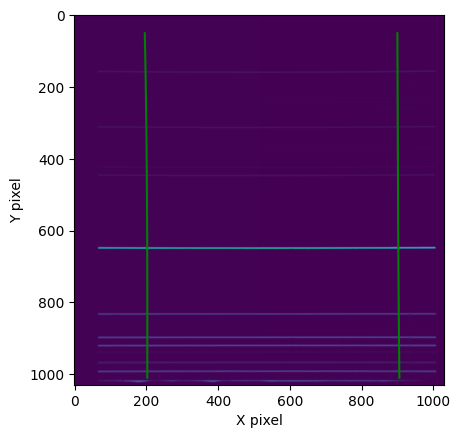

In [8]:
plt.figure()
plt.imshow(arc)
plt.plot(trace1[nframes//2],rows,color='g')
plt.plot(trace2[nframes//2],rows,color='g')
plt.ylabel('Y pixel')
plt.xlabel('X pixel')
plt.show()

Now let's extract the arc data at the location of the 2 traces whilst taking into account the fact that the trace starts from row 300 and ends at row 1670.

In [9]:
slice_arc_1 = []

slice_arc_2 = []

for i, r in enumerate(rows):
    row = arc[r]
    slice_arc_1.append(row[int(trace1[nframes//2][i])])
    slice_arc_2.append(row[int(trace2[nframes//2][i])])
       
slice_arc_1 = np.array(slice_arc_1)
slice_arc_2 = np.array(slice_arc_2)


Now let's plot the arcs extracted at these locations

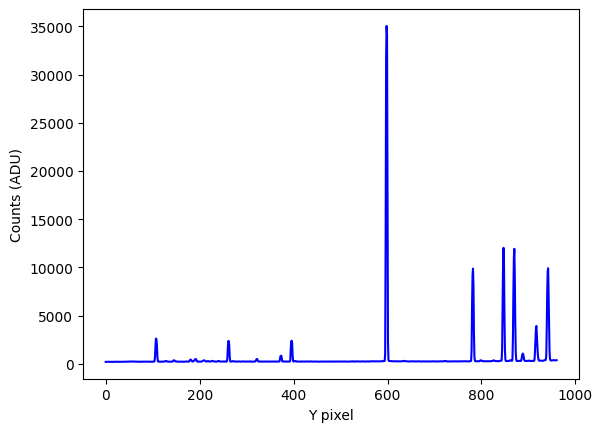

In [10]:
plt.figure()
plt.plot(slice_arc_1,color='b')
plt.xlabel('Y pixel')
plt.ylabel('Counts (ADU)')
plt.show()

And find the locations of these features, using the peakutils module which needs to be installed via:

_pip install peakutils_

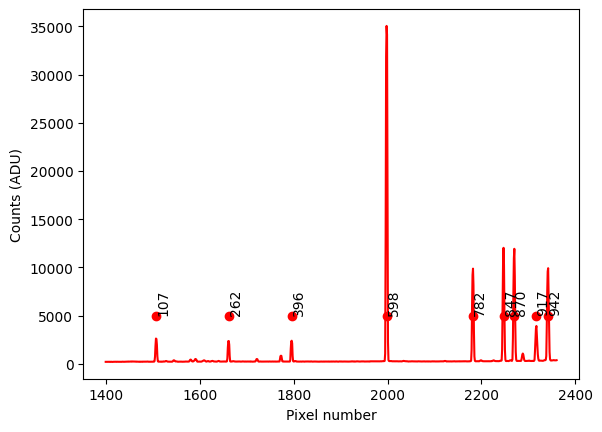

In [13]:
peaks_1 = peakutils.indexes(slice_arc_1.astype(int),thres=0.05,min_dist=10)

# Rescaling x axis to include the window [1100:3100] to make for easier comparison with ACAM calibration guide

plt.figure()
start_shift = 1100+300
start_shift = 3600
plt.plot(range(1100+300,1100+300+nrows),slice_arc_1,color='r')
plt.scatter(peaks_1+1100+300,[5000 for i in peaks_1],color='r')

for i in peaks_1:
        plt.text(i+1100+300,5010,str(i),rotation='vertical',verticalalignment='bottom')

plt.ylabel('Counts (ADU)')
plt.xlabel('Pixel number')
#plt.xlim(1900,2400)
plt.show()

Now using the above positions of the peaks we compare to the ACAM calibration manual (acam_wavelength_calibration.pdf) to find the corresponding wavelength for each. You will need to zoom-in significantly.

The plots above are given on the same x axis and scale as the graphs on pages 10-12 in the ACAM manual (unwindowed pixels). The peaks are annotated in the ACAM manual in units of Angstroms. The peaks in this notebook are annotated in windowed pixels, hence the offset with the x axis. What you need to do is match the peaks from the notebook, using the x axis, to the peaks in the manual. Then you record the numbers from the notebook, in windowed pixels, and match them to the numbers in Angstroms from the manual.

You will find some peaks that are either in the notebook but not the manual and vice versa. Don't worry about these peaks. As long as you have 15-20 matched peaks spanning the full wavelength range, this will be good enough.

You will know if something doesn't look right as a fit using a quadratic polynomial (wc.calc_wvl_solution) will lead to large outliers. You would then need to double check those outliers.



The above spectrum looks like it is a CuNe only spectrum. Now we assign each measured pixel to the wavelength:

In [14]:
lines1 = {5852.5:601,6030:653,6096.16:673,6143.06:687,6217.28:709,6266.5:724,6334.43:744,6402.25:764,\
         6678.28:845,6717.04:857,7032.41:949,7439.00:1068,8377.61:1340,8495.36:1375,8591.26:1402}

# this is my version of the lines from the above plot and the Grism#11 
lines1 = {3888.6:107,4471.5:262,5015.7:396,5875.6:598,6678.1:782,6965.4:847,7065.2:870,7384:917}

all_pixels_1 = np.array(sorted(lines1.values()))
all_wvls_1 = np.array(sorted(lines1.keys()))

Now using the above wavelengths and pixel positions let's fit a second order polynomial. Sometimes we need a higher order (not normally > 4) but here 2nd is fine.

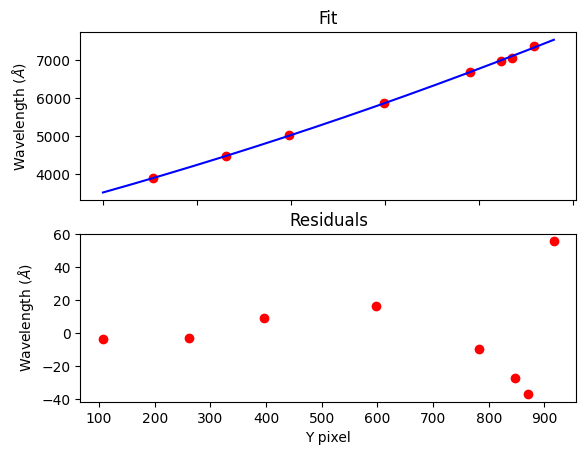

RMS residuals = 26.745338


In [15]:
wvl_1,poly_1,*rest = wc.calc_wvl_solution(all_pixels_1,all_wvls_1,2,s1[nframes//2])

In [16]:
print(poly_1)

           2
0.0007416 x + 3.483 x + 3511


Let's check how the solution from the arcs fits with the target's spectrum

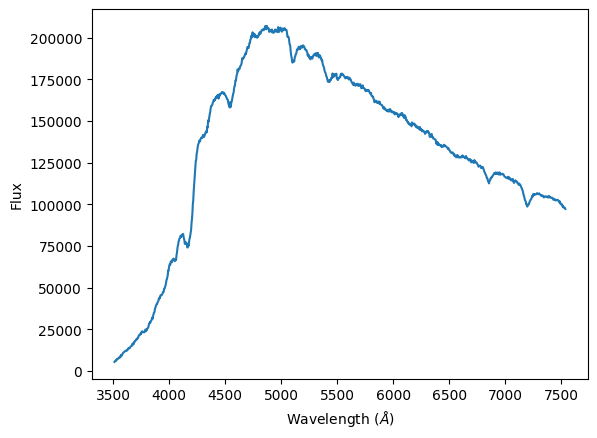

In [19]:
plt.figure()
plt.plot(wvl_1,s1[nframes//2])
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux')
plt.show()

Looks pretty close!

Now save the wavelength arc solution (note this commented for the example).

In [20]:
pickle.dump(wvl_1,open(parent_direc+'/pickled_objects/arc_solution_trace1.pickle','wb'))

Now let's do the same again but for the second trace

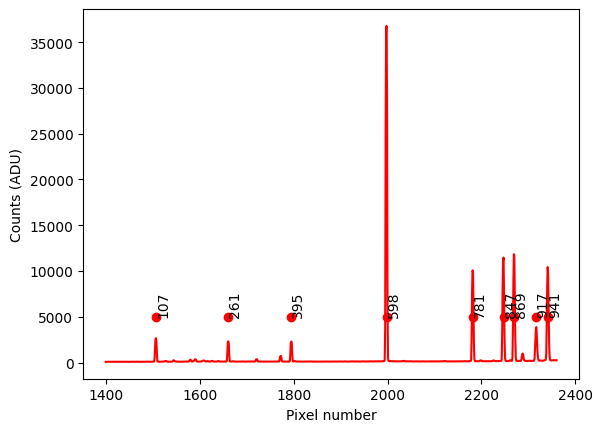

In [21]:
peaks_2 = peakutils.indexes(slice_arc_2.astype(int),thres=0.05,min_dist=10)

# Rescaling x axis to include the window [1100:3100] to make for easier comparison with ACAM calibration guide

plt.figure()
plt.plot(range(1100+300,1100+300+nrows),slice_arc_2,color='r')

plt.scatter(peaks_2+1100+300,[5000 for i in peaks_2],color='r')

for i in peaks_2:
        plt.text(i+1100+300,5010,str(i),rotation='vertical',verticalalignment='bottom')

plt.xlabel('Pixel number')        
plt.ylabel('Counts (ADU)')
plt.show()


In this case, the stars are very close together and there is little difference in the 2 pixel locations of the peaks. We can therefore use the wavelength solution from the first star. This is OK since this is not our final wavelength solution and we will also be resampling the spectra onto the same wavelength array.

However, this is not always true and in some cases a second arc solution may be needed.

MG: they are basically the same, a few are shifted by 1 pixel. Probably worth just saving as their own anyway.

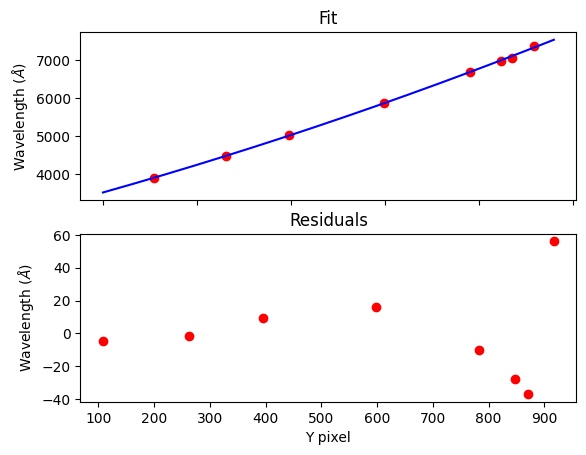

RMS residuals = 26.815088


In [22]:

# this is my version of the lines from the above plot and the Grism#11 
lines2 = {3888.6:108,4471.5:262,5015.7:396,5875.6:598,6678.1:782,6965.4:847,7065.2:870,7384:917}

all_pixels_2 = np.array(sorted(lines2.values()))
all_wvls_2 = np.array(sorted(lines2.keys()))

wvl_2,poly_2,*rest = wc.calc_wvl_solution(all_pixels_2,all_wvls_2,2,s2[nframes//2])

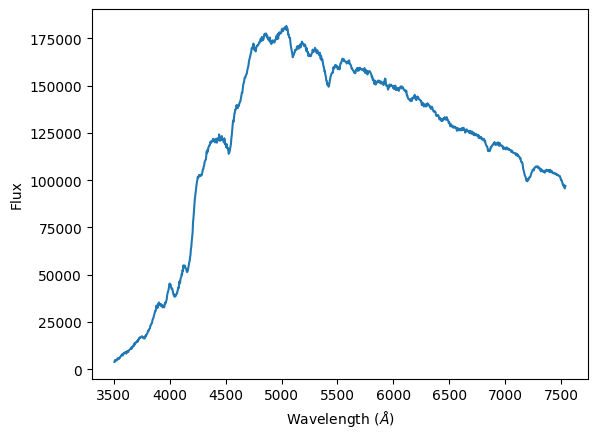

In [23]:
plt.figure()
plt.plot(wvl_2,s2[nframes//2])
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux')
plt.show()

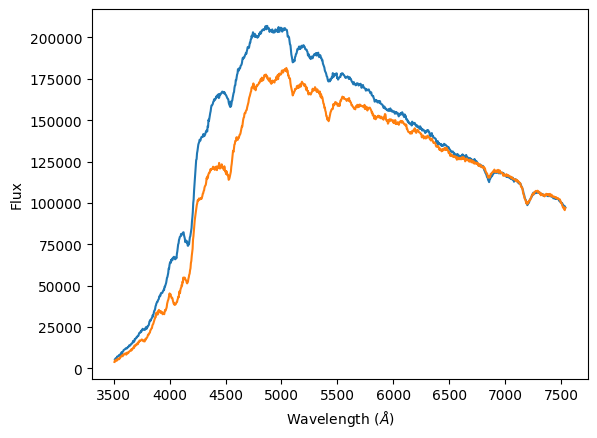

In [24]:
plt.figure()
plt.plot(wvl_1,s1[nframes//2])
plt.plot(wvl_2,s2[nframes//2])
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux')
plt.show()

In [25]:
pickle.dump(wvl_2,open(parent_direc+'/pickled_objects/arc_solution_trace2.pickle','wb'))

In [26]:
# arc_solution_trace2 = wvl_1

# pickle.dump(arc_solution_trace2,open('../pickled_objects/arc_solution_trace2.pickle','wb'))


We're now done and can move to notebook 3.